✅ Loaded 22 classes: ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun diseased (P1a)', 'Arjun healthy (P1b)', 'Bael diseased (P4b)', 'Basil healthy (P8)', 'Chinar diseased (P11b)', 'Chinar healthy (P11a)', 'Gauva diseased (P3b)', 'Gauva healthy (P3a)', 'Jamun diseased (P5b)', 'Jamun healthy (P5a)', 'Jatropha diseased (P6b)', 'Jatropha healthy (P6a)', 'Lemon diseased (P10b)', 'Lemon healthy (P10a)', 'Mango diseased (P0b)', 'Mango healthy (P0a)', 'Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)', 'Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']


C:\Users\20200306\AppData\Local\Temp\ipykernel_22536\3423213994.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locati

📷 Selected Image: ./resizedmerged\train\Arjun healthy (P1b)\0002_0087.JPG
✅ True Label: Arjun healthy (P1b)

🔍 alexnet90.pth ➤ Predicted: Arjun healthy (P1b)


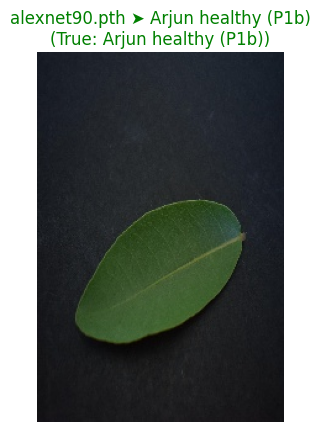


🔍 efficientnet_95.77.pth ➤ Predicted: Arjun healthy (P1b)


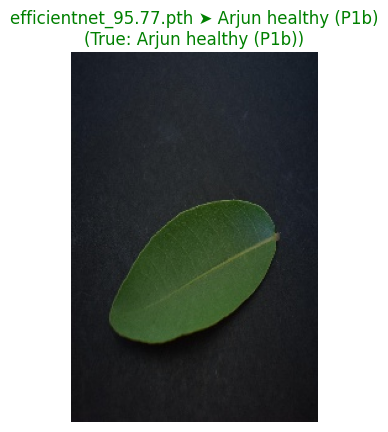


🔍 resnet50_91.pth ➤ Predicted: Arjun healthy (P1b)


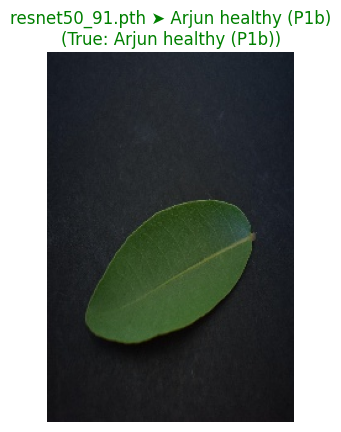


🔍 Resnet_94_5.pth ➤ Predicted: Arjun healthy (P1b)


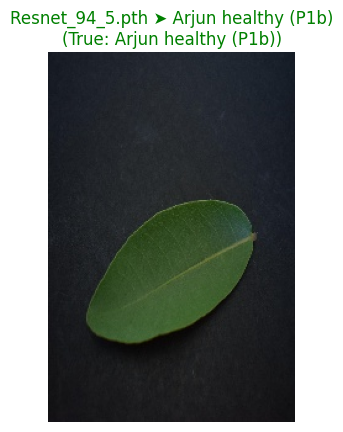


🔍 mobilenet_90.pth ➤ Predicted: Arjun healthy (P1b)


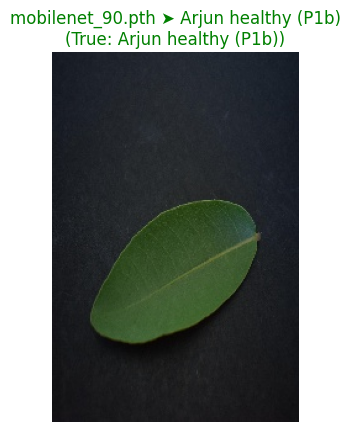


🔍 densenet_91_82.pth ➤ Predicted: Arjun healthy (P1b)


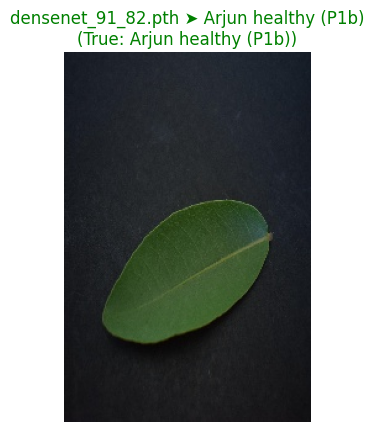


🔍 ConvNeXt_90.pth ➤ Predicted: Arjun healthy (P1b)


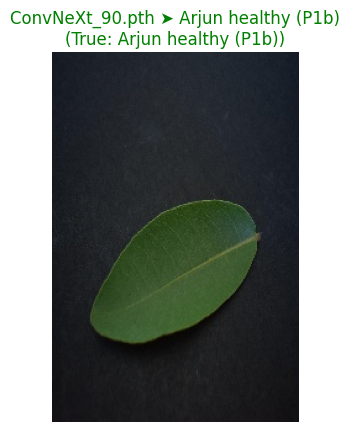


📊 Ensemble Hard Voting Accuracy: 99.22%


In [9]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import efficientnet_b0
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load CSV and Extract Classes ===
df = pd.read_csv('data.csv')
df['labels'] = df['labels'].apply(lambda x: x.split('-')[1])
classes = sorted(df['labels'].unique())
print(f"✅ Loaded {len(classes)} classes: {classes}")

# === Label Encoding ===
label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])

# === Train-Test Split ===
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
df_test['labels'] = label_encoder.transform(df_test['labels'])

# === Dataset Class ===
class LeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filepaths']
        label = self.dataframe.loc[idx, 'labels']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# === Transformations ===
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Model Files ===
model_paths = [
    "alexnet90.pth",
    "efficientnet_95.77.pth",
    "resnet50_91.pth",
    "Resnet_94_5.pth",
    "mobilenet_90.pth",
    "densenet_91_82.pth",
    "ConvNeXt_90.pth"
]

# === Load a Single Model (Reused for Prediction and Ensemble) ===
def load_model(model_path):
    model_name = os.path.basename(model_path).lower()

    if "efficientnet" in model_name:
        model = efficientnet_b0(weights='DEFAULT')
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(model.classifier[1].in_features, len(classes))
        )

    elif "alexnet" in model_name:
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(classes))

    elif "resnet50" in model_name:
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, len(classes)),
            nn.Dropout(0.25),
            nn.LogSoftmax(dim=1)
        )

    elif "resnet" in model_name:
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, len(classes))
        )

    elif "mobilenet" in model_name:
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[0].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(classes)),
            nn.LogSoftmax(dim=1)
        )

    elif "densenet" in model_name:
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(classes)),
            nn.LogSoftmax(dim=1)
        )

    elif "convnext" in model_name:
        model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
        model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(model.classifier[2].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, len(classes)),
            nn.LogSoftmax(dim=1)
        )
    else:
        raise ValueError("❌ Unknown model type.")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# === Load All Models Once ===
ensemble_models = [load_model(path) for path in model_paths]

# === Predict on a Random Image (Single Prediction Display) ===
random_sample = df_test.sample(n=1).iloc[0]
image_path = random_sample['filepaths']
true_label = label_encoder.inverse_transform([random_sample['labels']])[0]
image = Image.open(image_path).convert("RGB")
input_tensor = val_test_transform(image).unsqueeze(0).to(device)

print(f"📷 Selected Image: {image_path}")
print(f"✅ True Label: {true_label}")

for model_path, model in zip(model_paths, ensemble_models):
    model_name = os.path.basename(model_path)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_label = classes[predicted_idx.item()]
    
    color = 'green' if predicted_label == true_label else 'red'
    print(f"\n🔍 {model_name} ➤ Predicted: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{model_name} ➤ {predicted_label}\n(True: {true_label})", color=color)
    plt.show()

# === Create Test DataLoader ===
test_dataset = LeafDataset(df_test, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Ensemble Hard Voting Test Function ===
def test_ensemble(models, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Collect predictions from all models
            predictions = []
            for model in models:
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                predictions.append(preds.cpu().numpy())

            # Stack predictions and apply hard voting
            predictions = np.stack(predictions, axis=0)
            voted_preds, _ = mode(predictions, axis=0)
            voted_preds = torch.tensor(voted_preds.squeeze(), dtype=torch.long).to(device)

            correct += (voted_preds == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    return accuracy

# === Run Ensemble Evaluation ===
ensemble_accuracy = test_ensemble(ensemble_models, test_loader)
print(f"\n📊 Ensemble Hard Voting Accuracy: {ensemble_accuracy:.2f}%")
